In [1]:
from Helper.ml_models import * 
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks
import numpy as np
import pandas as pd

index = 199

2025-01-10 09:42:31.219923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-10 09:42:32.586114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = TrainedModel('deeplabv3_resnet101',
                     2048,
                     1024,
                     'deeplabv3_resnet101_k_fold_4',
                     folder_path='K_Fold_Run',
                     start_epoch='latest')

k_fold_dataset = K_Fold_Dataset(image_dir='CityscapesDaten/images',
                                            annotation_dir='CityscapesDaten/semantic',
                                            k_fold_csv_dir='Daten/CityscapesDaten',
                                            leave_out_fold=0)

k_fold_dataset.check_for_data_leaks()  

Using CUDA GPU
Model loaded: deeplabv3_resnet101 | Device: cuda 
own lrs: 1e-05
No data leaks found.


In [3]:
image, annotation = k_fold_dataset.test_dataset[index]
model.prepare_model_training(
    dataset_train=k_fold_dataset.train_dataset,
    dataset_val=k_fold_dataset.val_dataset,
    dataset_test=k_fold_dataset.test_dataset,
    batch_size=2, 
    shuffle=True,
    learning_rate=1e-5,
    num_workers=4,
    pin_memory=True
)

# Inferenz durchführen
output = model.inference(image)

# Vorhersage extrahieren
predicted = output.argmax(1).squeeze(0)  # Shape: (H, W)

print(type(predicted))

Training Dataset prepared
Validation Dataset prepared
Test Dataset prepared
own lrs: 1e-08
<class 'torch.Tensor'>


In [4]:
# Mittelwert und Standardabweichung aus dem Datensatz
mean = torch.tensor(k_fold_dataset.test_dataset.mean).view(3, 1, 1)
std = torch.tensor(k_fold_dataset.test_dataset.std).view(3, 1, 1)

# Bild zurücknormalisieren
image_unnorm = image * std + mean
image_unnorm = (image_unnorm * 255).type(torch.uint8)

# Alles auf die CPU verschieben
image_unnorm = image_unnorm.cpu()
predicted = predicted.cpu()
annotation = annotation.cpu()

# Anzahl der Klassen
num_classes = model.num_classes

# Masken für die Annotation erstellen
annotation_masks = annotation == torch.arange(num_classes).unsqueeze(1).unsqueeze(2)

# Masken für die Vorhersage erstellen
predicted_masks = predicted == torch.arange(num_classes).unsqueeze(1).unsqueeze(2)

# Masken in boolesche Tensors konvertieren
annotation_masks = annotation_masks.type(torch.bool)
predicted_masks = predicted_masks.type(torch.bool)

# Farben für die Klassen (aus dem Modell)
colors = model.city_label_color_map

# Bild mit der Annotation überlagern
image_with_annotation = draw_segmentation_masks(image_unnorm, annotation_masks, alpha=0.5, colors=colors)

# Bild mit der Vorhersage überlagern
image_with_prediction = draw_segmentation_masks(image_unnorm, predicted_masks, alpha=0.5, colors=colors)

# Dimensionen permutieren und in NumPy-Arrays konvertieren
image_with_annotation_np = image_with_annotation.permute(1, 2, 0).numpy()
image_with_prediction_np = image_with_prediction.permute(1, 2, 0).numpy()




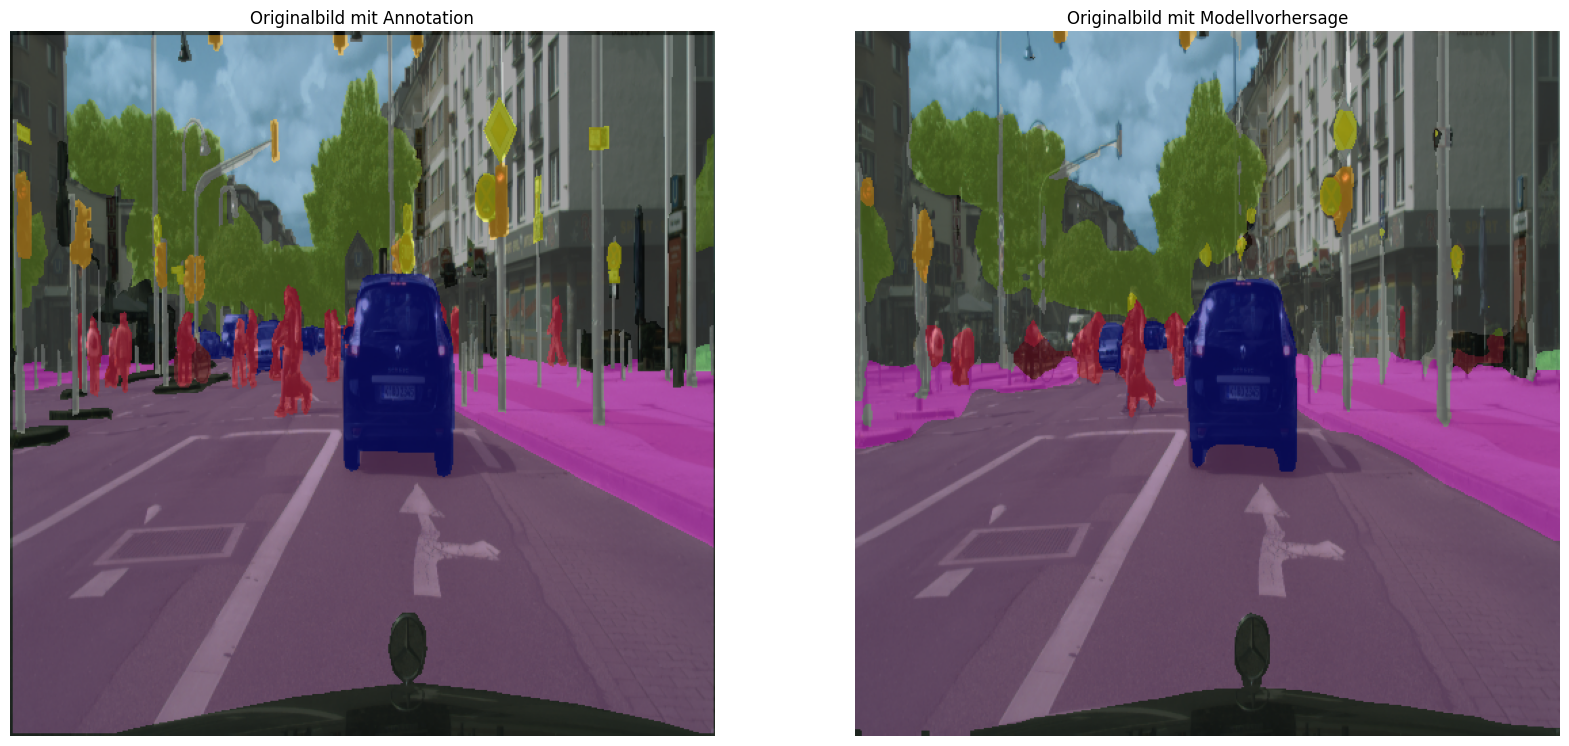

In [5]:
# Figuren und Achsen erstellen
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Linkes Bild: Original mit Annotation
axes[0].imshow(image_with_annotation_np)
axes[0].set_title('Originalbild mit Annotation')
axes[0].axis('off')

# Rechtes Bild: Original mit Vorhersage
axes[1].imshow(image_with_prediction_np)
axes[1].set_title('Originalbild mit Modellvorhersage')
axes[1].axis('off')

# Anzeigen der Bilder
plt.show()


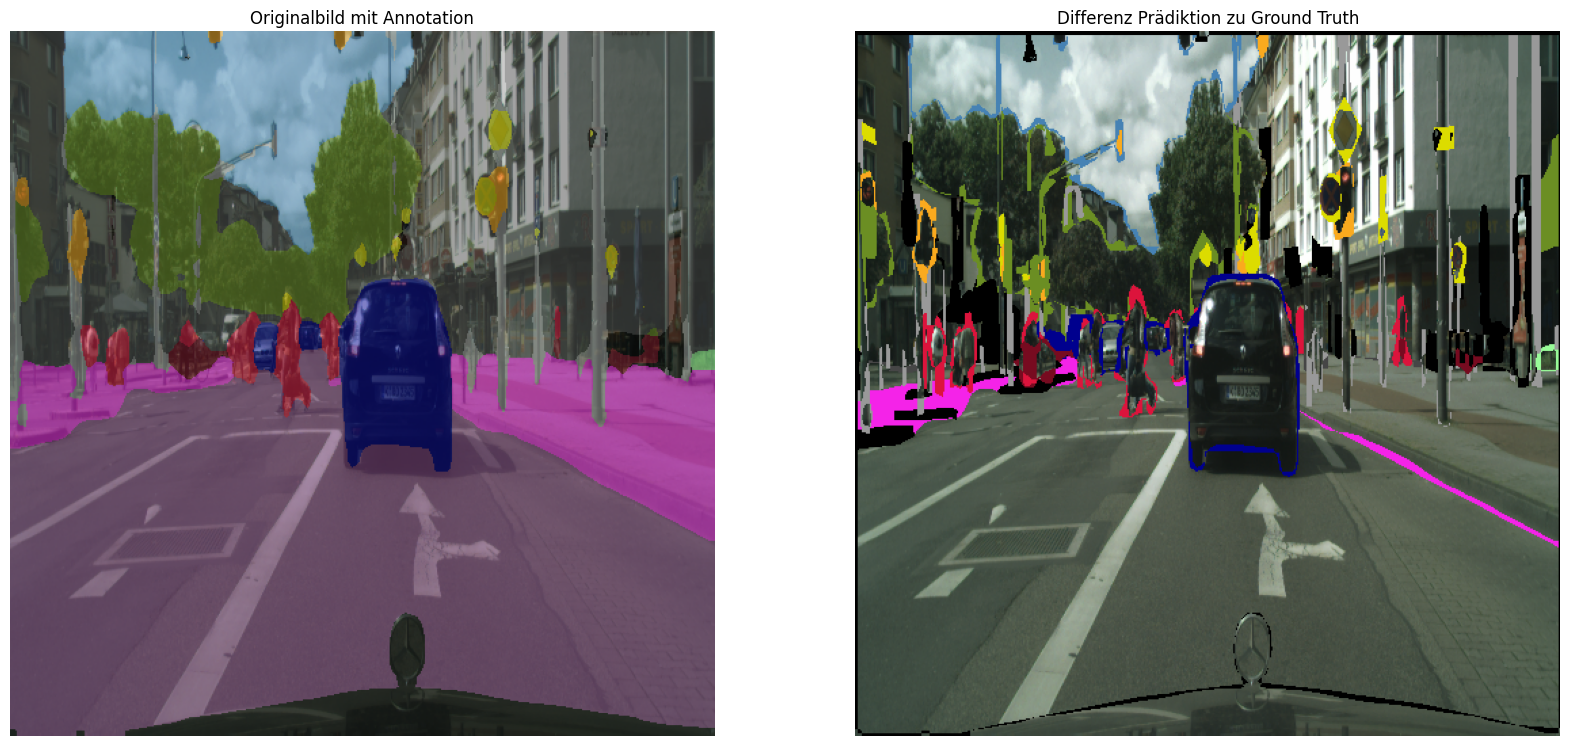

In [6]:
correct_mask = (predicted_masks == annotation_masks)
incorrect_mask = (predicted_masks != annotation_masks)

image_with_correct_mask = draw_segmentation_masks(image_unnorm, predicted_masks, alpha=0.5, colors=colors)
image_with_incorrect_mask = draw_segmentation_masks(image_unnorm, incorrect_mask, alpha=1, colors=colors)

# Figuren und Achsen erstellen
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Linkes Bild: Original mit Annotation
axes[0].imshow(image_with_correct_mask.permute(1, 2, 0).numpy())
axes[0].set_title('Originalbild mit Annotation')
axes[0].axis('off')

# Rechtes Bild: Original mit Vorhersage
axes[1].imshow(image_with_incorrect_mask.permute(1, 2, 0).numpy())
axes[1].set_title('Differenz Prädiktion zu Ground Truth')
axes[1].axis('off')

# Anzeigen der Bilder
plt.show()